In [6]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "C:/Users/Farhad/capsnet_traffic_sign_classifier/dataset/trainD.pickle"
validation_file= "C:/Users/Farhad/capsnet_traffic_sign_classifier/dataset/validD.pickle"
testing_file = "C:/Users/Farhad/capsnet_traffic_sign_classifier/dataset/testD.pickle"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Print the shape of variables
print(X_train.shape)
print(y_train.shape)

(34799L, 32L, 32L, 3L)
(34799L,)


In [7]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training example
n_train = X_train.shape[0]

# TODO: Number of validation example
n_validation = X_valid.shape[0]

# TODO: Number of testing example.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

('Number of training examples =', 34799L)
('Number of testing examples =', 12630L)
('Image data shape =', (32L, 32L, 3L))
('Number of classes =', 43)


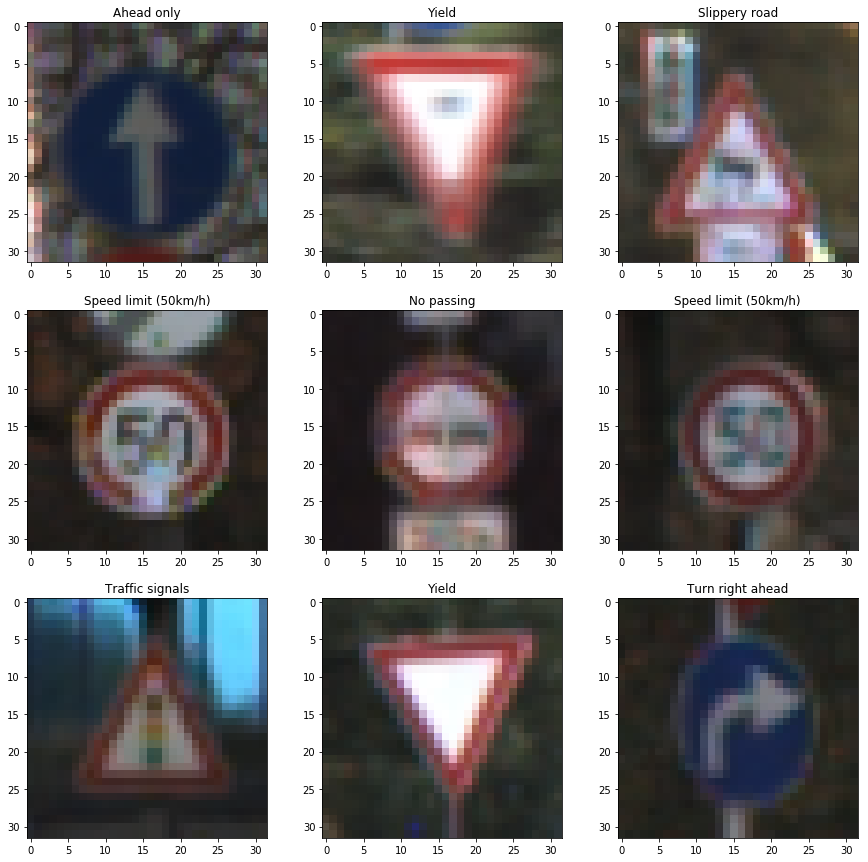

C:\Users\Farhad\Miniconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Most common index
index: 2 => Speed limit (50km/h) = 0.0591355252408731
index: 1 => Speed limit (30km/h) = 0.05825290546115858
index: 13 => Yield = 0.056487665901729524
index: 12 => Priority road = 0.055605046122015
index: 38 => Keep right = 0.05472242634230058
index: 10 => No passing for vehicles over 3.5 metric tons = 0.05295718678287143
index: 4 => Speed limit (70km/h) = 0.05207456700315691
index: 5 => Speed limit (80km/h) = 0.048544087884298814
index: 25 => Road work = 0.0397178900871535
index: 9 => No passing = 0.03883527030743905


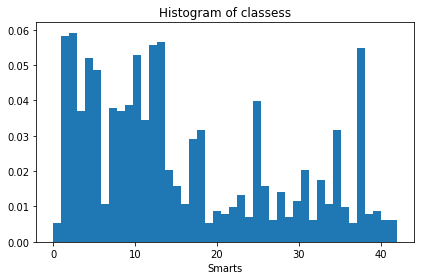

In [8]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import random
from PIL import Image, ImageEnhance
# Visualizations will be shown in the notebook.
%matplotlib inline

# Load name of id
with open("signnames.csv", "r") as f:
    signnames = f.read()
id_to_name = { int(line.split(",")[0]):line.split(",")[1] for line in signnames.split("\n")[1:] if len(line) > 0}


graph_size = 3
random_index_list = [random.randint(0, X_train.shape[0]) for _ in range(graph_size * graph_size)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_index_list):
    a=fig.add_subplot(graph_size, graph_size, i+1)
    #im = Image.fromarray(np.rollaxis(X_train[index] * 255, 0,3))
    imgplot = plt.imshow(X_train[index])
    # Plot some images
    a.set_title('%s' % id_to_name[y_train[index]])

plt.show()



fig, ax = plt.subplots()
# the histogram of the data
values, bins, patches = ax.hist(y_train, n_classes, normed=10)

# add a 'best fit' line
ax.set_xlabel('Smarts')
ax.set_title(r'Histogram of classess')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()

print ("Most common index")
most_common_index = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
for index in most_common_index[:10]:
    print("index: %s => %s = %s" % (index, id_to_name[index], values[index]))

In [10]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

#  I used keras only for the ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255



In [11]:
def preprocessing_function(img):
    """
        Custom preprocessing_function
    """
    img = img * 255
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.6, 1.5))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.6, 1.5))

    return np.array(img) / 255

train_datagen = ImageDataGenerator()
train_datagen_augmented = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocessing_function)
inference_datagen = ImageDataGenerator()
train_datagen.fit(X_train)
train_datagen_augmented.fit(X_train)
inference_datagen.fit(X_valid)
inference_datagen.fit(X_test)

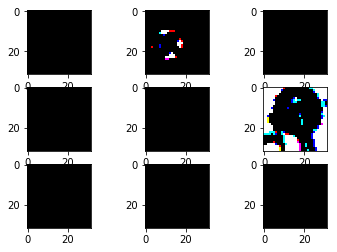

In [24]:
fig = plt.figure()

n = 0

graph_size = 3

for x_batch, y_batch in train_datagen_augmented.flow(X_train, y_train, batch_size=1):
    a=fig.add_subplot(graph_size, graph_size, n+1)
    imgplot = plt.imshow(x_batch[0])
    n = n + 1
    if n > 8:
        break

    
plt.show()

In [ ]:
plt.imshow(x_batch[0],cmap='rgb')

In [16]:
import numpy as np
import tensorflow as tf
import numpy as np


def conv_caps_layer(input_layer, capsules_size, nb_filters, kernel, stride=2):
    """
        Capsule layer for the convolutional inputs
        **input:
            *input_layer: (Tensor)
            *capsule_numbers: (Integer) the number of capsule in this layer.
            *kernel_size: (Integer) Size of the kernel for each filter.
            *stride: (Integer) 2 by default
    """
    # "In convolutional capsule layers each unit in a capsule is a convolutional unit.
    # Therefore, each capsule will output a grid of vectors rather than a single vector output."
    capsules = tf.contrib.layers.conv2d(
        input_layer, nb_filters * capsules_size, kernel, stride, padding="VALID")
    # conv shape: [?, kernel, kernel, nb_filters]
    shape = capsules.get_shape().as_list()
    capsules = tf.reshape(capsules, shape=(-1, np.prod(shape[1:3]) * nb_filters, capsules_size, 1))
    # capsules shape: [?, nb_capsules, capsule_size, 1]
    return squash(capsules)

def routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=4):
    """
        Routing algorithm

        **input:
            *u_hat: Dot product (weights between previous capsule and current capsule)
            *b_ij: the log prior probabilities that capsule i should be coupled to capsule j
            *nb_capsules_p: Number of capsule in the previous layer
            *nb_capsules: Number of capsule in this layer
    """
    # Start the routing algorithm
    for it in range(iterations):
        with tf.variable_scope('routing_' + str(it)):
            # Line 4 of algo
            # probabilities that capsule i should be coupled to capsule j.
            # c_ij:  [nb_capsules_p, nb_capsules, 1, 1]
            c_ij = tf.nn.softmax(b_ij, dim=2)

            # Line 5 of algo
            # c_ij:  [      nb_capsules_p, nb_capsules, 1,         1]
            # u_hat: [?,    nb_capsules_p, nb_capsules, len_v_j,   1]
            s_j = tf.multiply(c_ij, u_hat)
            # s_j: [?, nb_capsules_p, nb_capsules, len_v_j, 1]
            s_j = tf.reduce_sum(s_j, axis=1, keep_dims=True)
            # s_j: [?, 1, nb_capsules, len_v_j, 1)

            # line 6:
            # squash using Eq.1,
            v_j = squash(s_j)
            # v_j: [1, 1, nb_capsules, len_v_j, 1)

            # line 7:
            # Frist reshape & tile v_j
            # [? ,  1,              nb_capsules,    len_v_j, 1] ->
            # [?,   nb_capsules_p,  nb_capsules,    len_v_j, 1]
            v_j_tiled = tf.tile(v_j, [1, nb_capsules_p, 1, 1, 1])
            # u_hat:    [?,             nb_capsules_p, nb_capsules, len_v_j, 1]
            # v_j_tiled [1,             nb_capsules_p, nb_capsules, len_v_j, 1]
            u_dot_v = tf.matmul(u_hat, v_j_tiled, transpose_a=True)
            # u_produce_v: [?, nb_capsules_p, nb_capsules, 1, 1]
            b_ij += tf.reduce_sum(u_dot_v, axis=0, keep_dims=True)
            #b_ih: [1, nb_capsules_p, nb_capsules, 1, 1]

    return tf.squeeze(v_j, axis=1)

def fully_connected_caps_layer(input_layer, capsules_size, nb_capsules, iterations=4):
    """
        Second layer receiving inputs from all capsules of the layer below
            **input:
                *input_layer: (Tensor)
                *capsules_size: (Integer) Size of each capsule
                *nb_capsules: (Integer) Number of capsule
                *iterations: (Integer) Number of iteration for the routing algorithm

            i refer to the layer below.
            j refer to the layer above (the current layer).
    """
    shape = input_layer.get_shape().as_list()
    # Get the size of each capsule in the previous layer and the current layer.
    len_u_i = np.prod(shape[2])
    len_v_j = capsules_size
    # Get the number of capsule in the layer bellow.
    nb_capsules_p = np.prod(shape[1])

    # w_ij: Used to compute u_hat by multiplying the output ui of a capsule in the layer below
    # with this matrix
    # [nb_capsules_p, nb_capsules, len_v_j, len_u_i]
    _init = tf.random_normal_initializer(stddev=0.01, seed=0)
    _shape = (nb_capsules_p, nb_capsules, len_v_j, len_u_i)
    w_ij = tf.get_variable('weight', shape=_shape, dtype=tf.float32, initializer=_init)

    # Adding one dimension to the input [batch_size, nb_capsules_p,    length(u_i), 1] ->
    #                                   [batch_size, nb_capsules_p, 1, length(u_i), 1]
    # To allow the next dot product
    input_layer = tf.reshape(input_layer, shape=(-1, nb_capsules_p, 1, len_u_i, 1))
    input_layer = tf.tile(input_layer, [1, 1, nb_capsules, 1, 1])

    # Eq.2, calc u_hat
    # Prediction uj|i made by capsule i
    # w_ij:  [              nb_capsules_p, nb_capsules, len_v_j,  len_u_i, ]
    # input: [batch_size,   nb_capsules_p, nb_capsules, len_ui,   1]
    # u_hat: [batch_size,   nb_capsules_p, nb_capsules, len_v_j, 1]
    # Each capsule of the previous layer capsule layer is associated to a capsule of this layer
    u_hat = tf.einsum('abdc,iabcf->iabdf', w_ij, input_layer)

    # bij are the log prior probabilities that capsule i should be coupled to capsule j
    # [nb_capsules_p, nb_capsules, 1, 1]
    b_ij = tf.zeros(shape=[nb_capsules_p, nb_capsules, 1, 1], dtype=np.float32)

    return routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=iterations)

def squash(vector):
    """
        Squashing function corresponding to Eq. 1
        **input: **
            *vector
    """
    vector += 0.00001 # Workaround for the squashing function ...
    vec_squared_norm = tf.reduce_sum(tf.square(vector), -2, keep_dims=True)
    scalar_factor = vec_squared_norm / (1 + vec_squared_norm) / tf.sqrt(vec_squared_norm)
    vec_squashed = scalar_factor * vector  # element-wise
    return(vec_squashed)

In [17]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

import numpy as np
from model_base import ModelBase
import tensorflow as tf

class ModelTrafficSign(ModelBase):
    """
        ModelTrafficSign.
        This class is used to create the conv graph using:
            Dynamic Routing Between Capsules
    """

    # Numbers of label to predict
    NB_LABELS = 43

    def __init__(self, model_name, output_folder):
        """
            **input:
                *model_name: (Integer) Name of this model
                *output_folder: Output folder to saved data (tensorboard, checkpoints)
        """
        ModelBase.__init__(self, model_name, output_folder=output_folder)

    def _build_inputs(self):
        """
            Build tensorflow inputs
            (Placeholder)
            **return: **
                *tf_images: Images Placeholder
                *tf_labels: Labels Placeholder
        """
        # Images 32*32*3
        tf_images = tf.placeholder(tf.float32, [None, 32, 32, 3], name='images')
        # Labels: [0, 1, 6, 20, ...]
        tf_labels = tf.placeholder(tf.int64, [None], name='labels')
        return tf_images, tf_labels

    def _build_main_network(self, images, conv_2_dropout):
        """
            This method is used to create the two convolutions and the CapsNet on the top
            **input:
                *images: Image PLaceholder
                *conv_2_dropout: Dropout value placeholder
            **return: **
                *Caps1: Output of first Capsule layer
                *Caps2: Output of second Capsule layer
        """
        # First BLock:
        # Layer 1: Convolution.
        shape = (self.h.conv_1_size, self.h.conv_1_size, 3, self.h.conv_1_nb)
        conv1 = self._create_conv(self.tf_images, shape, relu=True, max_pooling=False, padding='VALID')
        # Layer 2: Convolution.
        #shape = (self.h.conv_2_size, self.h.conv_2_size, self.h.conv_1_nb, self.h.conv_2_nb)
        #conv2 = self._create_conv(conv1, shape, relu=True, max_pooling=False, padding='VALID')
        conv1 = tf.nn.dropout(conv1, keep_prob=conv_2_dropout)

        # Create the first capsules layer
        caps1 = conv_caps_layer(
            input_layer=conv1,
            capsules_size=self.h.caps_1_vec_len,
            nb_filters=self.h.caps_1_nb_filter,
            kernel=self.h.caps_1_size)
        # Create the second capsules layer used to predict the output
        caps2 = fully_connected_caps_layer(
            input_layer=caps1,
            capsules_size=self.h.caps_2_vec_len,
            nb_capsules=self.NB_LABELS,
            iterations=self.h.routing_steps)

        return caps1, caps2

    def _build_decoder(self, caps2, one_hot_labels, batch_size):
        """
            Build the decoder part from the last capsule layer
            **input:
                *Caps2:  Output of second Capsule layer
                *one_hot_labels
                *batch_size
        """
        labels = tf.reshape(one_hot_labels, (-1, self.NB_LABELS, 1))
        # squeeze(caps2):   [?, len_v_j,    capsules_nb]
        # labels:           [?, NB_LABELS,  1] with capsules_nb == NB_LABELS
        mask = tf.matmul(tf.squeeze(caps2), labels, transpose_a=True)
        # Select the good capsule vector
        capsule_vector = tf.reshape(mask, shape=(batch_size, self.h.caps_2_vec_len))
        # capsule_vector: [?, len_v_j]

        # Reconstruct image
        fc1 = tf.contrib.layers.fully_connected(capsule_vector, num_outputs=400)
        fc1 = tf.reshape(fc1, shape=(batch_size, 5, 5, 16))
        upsample1 = tf.image.resize_nearest_neighbor(fc1, (8, 8))
        conv1 = tf.layers.conv2d(upsample1, 4, (3,3), padding='same', activation=tf.nn.relu)

        upsample2 = tf.image.resize_nearest_neighbor(conv1, (16, 16))
        conv2 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)

        upsample3 = tf.image.resize_nearest_neighbor(conv2, (32, 32))
        conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)

        # 3 channel for RGG
        logits = tf.layers.conv2d(conv6, 3, (3,3), padding='same', activation=None)
        decoded = tf.nn.sigmoid(logits, name='decoded')
        tf.summary.image('reconstruction_img', decoded)

        return decoded

    def init(self):
        """
            Init the graph
        """
        # Get graph inputs
        self.tf_images, self.tf_labels = self._build_inputs()
        # Dropout inputs
        self.tf_conv_2_dropout = tf.placeholder(tf.float32, shape=(), name='conv_2_dropout')
        # Dynamic batch size
        batch_size = tf.shape(self.tf_images)[0]
        # Translate labels to one hot array
        one_hot_labels = tf.one_hot(self.tf_labels, depth=self.NB_LABELS)
        # Create the first convolution and the CapsNet
        self.tf_caps1, self.tf_caps2 = self._build_main_network(self.tf_images, self.tf_conv_2_dropout)

        # Build the images reconstruction
        self.tf_decoded = self._build_decoder(self.tf_caps2, one_hot_labels, batch_size)

        # Build the loss
        _loss = self._build_loss(
            self.tf_caps2, one_hot_labels, self.tf_labels, self.tf_decoded, self.tf_images)
        (self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_predicted_class,
         self.tf_correct_prediction, self.tf_accuracy, self.tf_loss, self.tf_margin_loss,
         self.tf_reconstruction_loss) = _loss

        # Build optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.h.learning_rate)
        self.tf_optimizer = optimizer.minimize(self.tf_loss, global_step=tf.Variable(0, trainable=False))

        # Log value into tensorboard
        tf.summary.scalar('margin_loss', self.tf_margin_loss)
        tf.summary.scalar('accuracy', self.tf_accuracy)
        tf.summary.scalar('total_loss', self.tf_loss)
        tf.summary.scalar('reconstruction_loss', self.tf_reconstruction_loss)

        self.tf_test = tf.random_uniform([2], minval=0, maxval=None, dtype=tf.float32, seed=None, name="tf_test")

        self.init_session()


    def _build_loss(self, caps2, one_hot_labels, labels, decoded, images):
        """
            Build the loss of the graph
        """
        # Get the length of each capsule
        capsules_length = tf.sqrt(tf.reduce_sum(tf.square(caps2), axis=2, keep_dims=True))

        max_l = tf.square(tf.maximum(0., 0.9 - capsules_length))
        max_l = tf.reshape(max_l, shape=(-1, self.NB_LABELS))
        max_r = tf.square(tf.maximum(0., capsules_length - 0.1))
        max_r = tf.reshape(max_r, shape=(-1, self.NB_LABELS))
        t_c = one_hot_labels
        m_loss = t_c * max_l + 0.5 * (1 - t_c) * max_r
        margin_loss_sum = tf.reduce_sum(m_loss, axis=1)
        margin_loss = tf.reduce_mean(margin_loss_sum)

        # Reconstruction loss
        loss_squared_rec = tf.square(decoded - images)
        reconstruction_loss = tf.reduce_mean(loss_squared_rec)

        # 3. Total loss
        loss = margin_loss + (0.0005 * reconstruction_loss)

        # Accuracy
        predicted_class = tf.argmax(capsules_length, axis=1)
        predicted_class = tf.reshape(predicted_class, [tf.shape(capsules_length)[0]])
        correct_prediction = tf.equal(predicted_class, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        return (loss_squared_rec, margin_loss_sum, predicted_class, correct_prediction, accuracy,
                loss, margin_loss, reconstruction_loss)

    def optimize(self, images, labels, tb_save=True):
        """
            Train the model
            **input: **
                *images: Image to train the model on
                *labels: True classes
                *tb_save: (Boolean) Log this optimization in tensorboard
            **return: **
                Loss: The loss of the model on this batch
                Acc: Accuracy of the model on this batch
        """
        tensors = [self.tf_optimizer, self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        _, loss, acc, summary = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: self.h.conv_2_dropout
        })

        if tb_save:
            # Write data to tensorboard
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    def evaluate(self, images, labels, tb_train_save=False, tb_test_save=False):
        """
            Evaluate dataset
            **input: **
                *images: Image to train the model on
                *labels: True classes
                *tb_train_save: (Boolean) Log this optimization in tensorboard under the train part
                *tb_test_save: (Boolean) Log this optimization in tensorboard under the test part
            **return: **
                Loss: The loss of the model on this batch
                Acc: Accuracy of the model on this batch
        """
        tensors = [self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        loss, acc, summary = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images,
                self.tf_labels: labels,
                self.tf_conv_2_dropout: 1.
            })

        if tb_test_save:
            # Write data to tensorboard
            self.test_writer.add_summary(summary, self.test_writer_it)
            self.test_writer_it += 1

        if tb_train_save:
            # Write data to tensorboard
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    def predict(self, images):
        """
            Method used to predict a class
            Return a softmax
            **input: **
                *images: Image to train the model on
            **return:
                *softmax: Softmax between all capsules
        """
        tensors = [self.tf_caps2]

        caps2 = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_conv_2_dropout: 1.
        })[0]

        # tf.sqrt(tf.reduce_sum(tf.square(caps2), axis=2, keep_dims=True))
        caps2 = np.sqrt(np.sum(np.square(caps2), axis=2, keepdims=True))
        caps2 = np.reshape(caps2, (len(images), self.NB_LABELS))
        # softmax
        softmax = np.exp(caps2) / np.sum(np.exp(caps2), axis=1, keepdims=True)

        return softmax

    def reconstruction(self, images, labels):
        """
            Method used to get the reconstructions given a batch
            Return the result as a softmax
            **input: **
                *images: Image to train the model on
                *labels: True classes
        """
        tensors = [self.tf_decoded]

        decoded = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: 1.
        })[0]

        return decoded

    def evaluate_dataset(self, images, labels, batch_size=10):
        """
            Evaluate a full dataset
            This method is used to fully evaluate the dataset batch per batch. Useful when
            the dataset can't be fit inside to the GPU.
            *input: **
                *images: Image to train the model on
                *labels: True classes
            *return: **
                *loss: Loss overall your dataset
                *accuracy: Accuracy overall your dataset
                *predicted_class: Predicted class
        """
        tensors = [self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_correct_prediction,
                   self.tf_predicted_class]

        loss_squared_rec_list = None
        margin_loss_sum_list = None
        correct_prediction_list = None
        predicted_class = None

        b = 0
        for batch in self.get_batches([images, labels], batch_size, shuffle=False):
            images_batch, labels_batch = batch
            loss_squared_rec, margin_loss_sum, correct_prediction, classes = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images_batch,
                self.tf_labels: labels_batch,
                self.tf_conv_2_dropout: 1.
            })
            if loss_squared_rec_list is not None:
                predicted_class = np.concatenate((predicted_class, classes))
                loss_squared_rec_list = np.concatenate((loss_squared_rec_list, loss_squared_rec))
                margin_loss_sum_list = np.concatenate((margin_loss_sum_list, margin_loss_sum))
                correct_prediction_list = np.concatenate((correct_prediction_list, correct_prediction))
            else:
                predicted_class = classes
                loss_squared_rec_list = loss_squared_rec
                margin_loss_sum_list = margin_loss_sum
                correct_prediction_list = correct_prediction
            b += batch_size

        margin_loss = np.mean(margin_loss_sum_list)
        reconstruction_loss = np.mean(loss_squared_rec_list)
        accuracy = np.mean(correct_prediction_list)

        loss = margin_loss

        return loss, accuracy, predicted_class

In [18]:
# Init model
model = ModelTrafficSign("TrafficSign", output_folder="outputs")
model.init()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


From <ipython-input-16-dd02c8ee4fa1>:123: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
dim is deprecated, use axis instead


From <ipython-input-16-dd02c8ee4fa1>:41: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


In [19]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

BATCH_SIZE = 50

# Utils method to print the current progression
def plot_progression(b, cost, acc, label): print(
    "[%s] Batch ID = %s, loss = %s, acc = %s" % (label, b, cost, acc))

# Training pipeline
b = 0
valid_batch = inference_datagen.flow(X_valid, y_valid, batch_size=BATCH_SIZE)
best_validation_loss = None
augmented_factor = 0.99
decrease_factor = 0.90
train_batches = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
augmented_train_batches = train_datagen_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE)

while True:
    next_batch = next(
        augmented_train_batches if random.uniform(0, 1) < augmented_factor else train_batches)
    x_batch, y_batch = next_batch

    ### Training
    cost, acc = model.optimize(x_batch, y_batch)
    ### Validation
    x_batch, y_batch = next(valid_batch, None)
    # Retrieve the cost and acc on this validation batch and save it in tensorboard
    cost_val, acc_val = model.evaluate(x_batch, y_batch, tb_test_save=True)

    if b % 10 == 0: # Plot the last results
        plot_progression(b, cost, acc, "Train")
        plot_progression(b, cost_val, acc_val, "Validation")
    if b % 1000 == 0: # Test the model on all the validation
        print("Evaluate full validation dataset ...")
        loss, acc, _ = model.evaluate_dataset(X_valid, y_valid)
        print("Current loss: %s Best loss: %s" % (loss, best_validation_loss))
        plot_progression(b, loss, acc, "TOTAL Validation")
        if best_validation_loss is None or loss < best_validation_loss:
            best_validation_loss = loss
            model.save()
        augmented_factor = augmented_factor * decrease_factor
        print("Augmented Factor = %s" % augmented_factor)

    b += 1



[Train] Batch ID = 0, loss = 0.8419808, acc = 0.14
[Validation] Batch ID = 0, loss = 1.1856773, acc = 0.04
Evaluate full validation dataset ...


ModelBase::Saving model ...


Current loss: 1.102926 Best loss: None
[TOTAL Validation] Batch ID = 0, loss = 1.102926, acc = 0.031292517006802724


ModelBase::Model successfully saved here: outputs\checkpoints\c1vl_16_c1nf_16_rs_1_c1s_5_c2s_6_c1s_9_lr_0.0001_c2vl_32_c1n_256_c2n_64_c2d_0.7--TrafficSign--1573148867.87


Augmented Factor = 0.891
[Train] Batch ID = 10, loss = 0.78905576, acc = 0.06
[Validation] Batch ID = 10, loss = 0.8089565, acc = 0.02
[Train] Batch ID = 20, loss = 0.801492, acc = 0.0
[Validation] Batch ID = 20, loss = 0.7722983, acc = 0.02
[Train] Batch ID = 30, loss = 0.792463, acc = 0.04
[Validation] Batch ID = 30, loss = 0.7802588, acc = 0.02
[Train] Batch ID = 40, loss = 0.7477885, acc = 0.08
[Validation] Batch ID = 40, loss = 0.7618954, acc = 0.0
[Train] Batch ID = 50, loss = 0.7976881, acc = 0.02
[Validation] Batch ID = 50, loss = 0.7787078, acc = 0.06
[Train] Batch ID = 60, loss = 0.7879812, acc = 0.02
[Validation] Batch ID = 60, loss = 0.7510919, acc = 0.12
[Train] Batch ID = 70, loss = 0.80164087, acc = 0.02
[Validation] Batch ID = 70, loss = 0.7680587, acc = 0.04
[Train] Batch ID = 80, loss = 0.76662135, acc = 0.0
[Validation] Batch ID = 80, loss = 0.75231385, acc = 0.06
[Train] Batch ID = 90, loss = 0.79175997, acc = 0.04
[Validation] Batch ID = 90, loss = 0.7542109, acc =

[Train] Batch ID = 750, loss = 0.58398074, acc = 0.12
[Validation] Batch ID = 750, loss = 0.59710526, acc = 0.08
[Train] Batch ID = 760, loss = 0.59497124, acc = 0.06
[Validation] Batch ID = 760, loss = 0.5518592, acc = 0.08
[Train] Batch ID = 770, loss = 0.60584295, acc = 0.04
[Validation] Batch ID = 770, loss = 0.5736252, acc = 0.1
[Train] Batch ID = 780, loss = 0.59526247, acc = 0.12
[Validation] Batch ID = 780, loss = 0.61930585, acc = 0.08
[Train] Batch ID = 790, loss = 0.60044897, acc = 0.02
[Validation] Batch ID = 790, loss = 0.52149373, acc = 0.28
[Train] Batch ID = 800, loss = 0.5210716, acc = 0.22
[Validation] Batch ID = 800, loss = 0.5584793, acc = 0.1
[Train] Batch ID = 810, loss = 0.58756715, acc = 0.08
[Validation] Batch ID = 810, loss = 0.5698097, acc = 0.16
[Train] Batch ID = 820, loss = 0.6026059, acc = 0.04
[Validation] Batch ID = 820, loss = 0.5896397, acc = 0.16
[Train] Batch ID = 830, loss = 0.58115524, acc = 0.12
[Validation] Batch ID = 830, loss = 0.5685686, acc 

ModelBase::Saving model ...


Current loss: 0.58705777 Best loss: 1.102926
[TOTAL Validation] Batch ID = 1000, loss = 0.58705777, acc = 0.10884353741496598


ModelBase::Model successfully saved here: outputs\checkpoints\c1vl_16_c1nf_16_rs_1_c1s_5_c2s_6_c1s_9_lr_0.0001_c2vl_32_c1n_256_c2n_64_c2d_0.7--TrafficSign--1573148867.87


Augmented Factor = 0.8019
[Train] Batch ID = 1010, loss = 0.5905632, acc = 0.06
[Validation] Batch ID = 1010, loss = 0.56229717, acc = 0.2
[Train] Batch ID = 1020, loss = 0.5878034, acc = 0.14
[Validation] Batch ID = 1020, loss = 0.5962479, acc = 0.1
[Train] Batch ID = 1030, loss = 0.5861681, acc = 0.1
[Validation] Batch ID = 1030, loss = 0.5840587, acc = 0.14
[Train] Batch ID = 1040, loss = 0.5599403, acc = 0.08
[Validation] Batch ID = 1040, loss = 0.5603327, acc = 0.12
[Train] Batch ID = 1050, loss = 0.5363754, acc = 0.22
[Validation] Batch ID = 1050, loss = 0.59535164, acc = 0.08
[Train] Batch ID = 1060, loss = 0.59031504, acc = 0.04
[Validation] Batch ID = 1060, loss = 0.5823856, acc = 0.14
[Train] Batch ID = 1070, loss = 0.52913266, acc = 0.18
[Validation] Batch ID = 1070, loss = 0.58262193, acc = 0.1
[Train] Batch ID = 1080, loss = 0.60708433, acc = 0.1
[Validation] Batch ID = 1080, loss = 0.57648605, acc = 0.14
[Train] Batch ID = 1090, loss = 0.5936396, acc = 0.06
[Validation] B

[Train] Batch ID = 1740, loss = 0.47330752, acc = 0.28
[Validation] Batch ID = 1740, loss = 0.54880124, acc = 0.16
[Train] Batch ID = 1750, loss = 0.56575036, acc = 0.18
[Validation] Batch ID = 1750, loss = 0.5281856, acc = 0.16
[Train] Batch ID = 1760, loss = 0.5229343, acc = 0.24
[Validation] Batch ID = 1760, loss = 0.5196019, acc = 0.22
[Train] Batch ID = 1770, loss = 0.52421033, acc = 0.18
[Validation] Batch ID = 1770, loss = 0.54457384, acc = 0.18
[Train] Batch ID = 1780, loss = 0.53425604, acc = 0.22
[Validation] Batch ID = 1780, loss = 0.58555746, acc = 0.12
[Train] Batch ID = 1790, loss = 0.61035013, acc = 0.0
[Validation] Batch ID = 1790, loss = 0.53166884, acc = 0.2
[Train] Batch ID = 1800, loss = 0.5956373, acc = 0.04
[Validation] Batch ID = 1800, loss = 0.5962638, acc = 0.12
[Train] Batch ID = 1810, loss = 0.5827696, acc = 0.06
[Validation] Batch ID = 1810, loss = 0.5602657, acc = 0.14


KeyboardInterrupt: 

In [22]:
# Test the model on the test set

# Evaluate all the dataset
loss, acc, predicted_class = model.evaluate_dataset(X_test, y_test)

print("Test Accuracy = ", acc)
print("Test Loss = ", loss)

('Test Accuracy = ', 0.18812351543942993)
('Test Loss = ', 0.54593474)


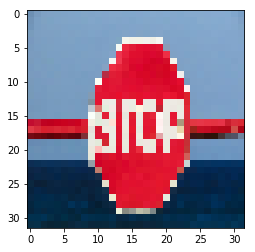

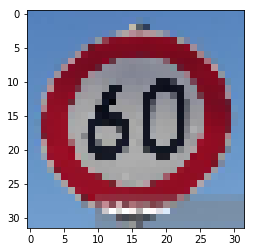

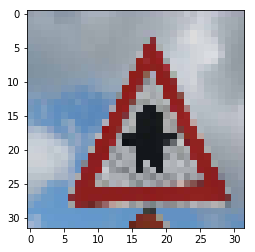

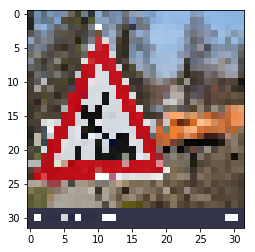

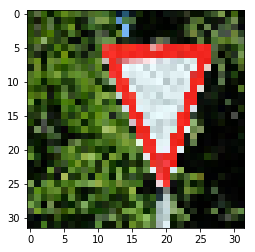

In [25]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
images = []

# Read all image into the folder
for filename in os.listdir("from_web"):
    img = Image.open(os.path.join("from_web", filename))
    img = img.resize((32, 32))
    plt.imshow(img)
    plt.show()
    img = np.array(img) / 255
    images.append(img)
    

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# Get the prediction
predictions = model.predict(images)